In [1]:
import pandas as pd

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [2]:
y = pd.read_csv('AAPL_quarterly_financials.csv')

In [3]:
y.index = y.name

In [4]:
y = pd.DataFrame(y.loc['BasicEPS', :]).iloc[2:,:]

In [16]:
y.head()

,BasicEPS
09/30/2023,1.47
06/30/2023,1.27
03/31/2023,1.53
12/31/2022,1.89
09/30/2022,1.29


In [5]:
y.index = pd.to_datetime(y.index)

In [6]:
y = y.fillna(0.).sort_index()

In [8]:
y

,BasicEPS
1985-09-30,0.0
1985-12-31,0.004
1986-03-31,0.002
1986-06-30,0.002
1986-09-30,0.0
...,...
2022-09-30,1.29
2022-12-31,1.89
2023-03-31,1.53
2023-06-30,1.27


# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data. Clean it to have a quarterly average.

In [7]:
from pytrends.request import TrendReq

In [9]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Apple revenue",
    "iPhone sales",
    "Apple stock price",
    "MacBook demand",
    "Apple services",
    "iPad sales",    
    "Apple pie recipe",
    "New York weather",
    "Hollywood movies"]  
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [14]:
X = df.resample("Q").mean()

In [16]:
# ALIGN DATA
temp = pd.concat([y, X],axis = 1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

In [13]:
df

,Apple revenue,iPhone sales,Apple stock price,MacBook demand,Apple services,iPad sales,Apple pie recipe,New York weather,Hollywood movies
date,,,,,,,,,
2004-03-31,19.000000,0.666667,0.666667,13.333333,34.333333,0.000000,12.666667,50.666667,8.333333
2004-06-30,0.000000,0.000000,1.000000,18.666667,41.333333,0.000000,10.333333,40.333333,9.000000
2004-09-30,0.000000,0.666667,0.333333,0.000000,43.000000,0.000000,18.666667,38.000000,8.000000
2004-12-31,13.333333,0.000000,0.666667,39.333333,37.000000,0.000000,36.000000,41.666667,7.666667
2005-03-31,23.000000,0.000000,2.000000,16.666667,51.000000,0.000000,10.666667,57.333333,7.333333
...,...,...,...,...,...,...,...,...,...
2023-03-31,80.666667,14.000000,34.666667,7.333333,76.666667,5.000000,10.000000,39.666667,23.666667
2023-06-30,79.000000,13.333333,33.000000,6.000000,75.666667,5.000000,8.000000,40.333333,25.666667
2023-09-30,82.666667,18.000000,31.333333,5.666667,85.000000,5.333333,15.333333,40.333333,26.666667


# 3.) Normalize all the X data

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda . Plot a bar chart.

In [36]:
import matplotlib.pyplot as plt
lasso  = Lasso(alpha=0.2)
lasso= lasso.fit(X_scaled,y)

In [37]:
lasso.coef_

array([ 0.12931242,  0.        ,  0.12042171, -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        ])

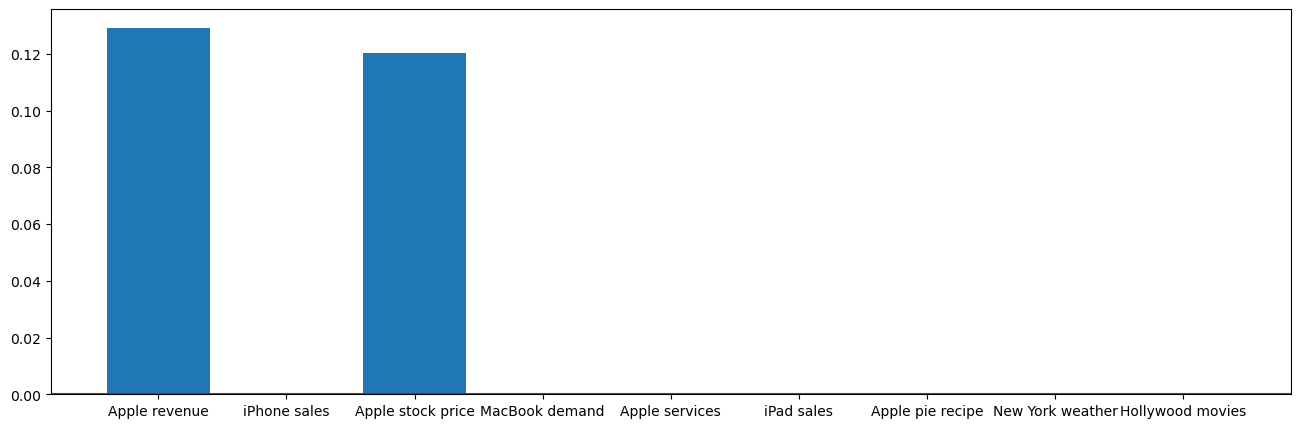

In [38]:
plt.figure( figsize =(16,5))
# plt.bar(range(len(coefficients)), coefficients)
plt.bar(X.columns, lasso.coef_)
plt.axhline(0, color = 'red')
plt.show()

# 5.) Do these coefficient magnitudes make sense?

The non-zero coefficients for some of these terms (like "Apple revenue" or "iPhone sales") make sense, as these areas are likely to have a direct impact on Apple's earnings. Their search trends could reflect consumer interest and market trends, which are valuable for predicting earnings.


The zero coefficients for variables like "Apple pie recipe", "New York weather", "Hollywood movies" here suggest that the corresponding features do not contribute meaningfully to the model, and Lasso has effectively removed them from the model. 